In [164]:
import re
import streamlit as st
from sympy.physics.continuum_mechanics import Beam
import sympy
from sympy import SingularityFunction

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

st.write("""
# Simple Beam Analysis

""")

st.sidebar.header('User Input Parameters')

def user_input_features(): 
    # Beam Length in Meters
    beam_length = st.sidebar.slider('Beam Length', 5.0, 25.0, 10.0, step=2.5)
    # Start Supports
    start_Support = st.sidebar.selectbox('Start Support',('Fix', 'Pin', 'Roller'))
    end_Support = st.sidebar.selectbox('End Support',('Fix', 'Pin'))

    #Point Load in kN
    point_load = st.sidebar.slider('Point Load Magnitude', 0.0, 25.0, 10.0, step=5.0)

    point_load_loc = st.sidebar.slider('Point Load Loc:', 0.0, beam_length, 3.0, step=2.5)
    
    # Udl load is in kN/m
    udl_load = st.sidebar.slider('UDL Magnitude', 0.0, 25.0, 5.0 ,step = 5.0)

    udl_start_loc = st.sidebar.slider('UDL Start Loc', 0.0, beam_length - 5.0, 0.0, step=2.5)
    udl_end_loc = st.sidebar.slider('UDL End Loc', udl_start_loc+2.5, beam_length, beam_length, step=2.5)

    #Point Load in kN-m
    moment_load = st.sidebar.slider('Moment Magnitude', -20.0, 20.0, 0.0, step=5.0)

    moment_loc = st.sidebar.slider('Moment Loc:', 0.0, beam_length, 4.0, step=2.5)

    
    data = {'beam_length': beam_length,
            'start_Support': start_Support,
            'end_Support': end_Support,
            'E': 25000.0,
            'Izz': 0.0005}

    features = pd.DataFrame(data, index=[0])
    beam_data = [beam_length, start_Support, end_Support]

    point_data = [point_load, point_load_loc]
    
    moment_data = [moment_load, moment_loc]
    
    UDL_data = [udl_load, udl_start_loc, udl_end_loc]

    return features, beam_data, point_data, moment_data, UDL_data

df, beam_data, point_data, moment_data, UDL_data = user_input_features()

st.subheader('User Input parameters')
st.write(df)

# Logic
E = 25000
I = 0.0005

#print(beam_data, point_data)

L = beam_data[0]
lt_sprt = beam_data[1]
rt_sprt = beam_data[2]

beam_inst = Beam(L, E, I)

def sympy_variable(x:str):
        return sympy.symbols(x)

def apply_end_support_loads(beam_inst, L):
    sympy_symbols = []
    beam_inst.bc_deflection = []
    beam_inst.bc_slope = []
    if lt_sprt == "Fix":
        R_0 = sympy_variable("R_0")
        M_0 = sympy_variable("M_0")
        sympy_symbols.append(R_0)
        sympy_symbols.append(M_0)
        beam_inst.apply_load(R_0, 0, -1)
        beam_inst.apply_load(M_0, 0, -2)
        beam_inst.bc_deflection.append((0,0))
        beam_inst.bc_slope.append((0,0))
    else:
        R_0 = sympy_variable("R_0")
        sympy_symbols.append(R_0)
        beam_inst.apply_load(R_0, 0, -1)
        beam_inst.bc_deflection.append((0,0))

    if rt_sprt == "Fix":
        r_end = sympy_variable("R_" + str(L))
        m_end = sympy_variable("M_" + str(L))
        sympy_symbols.append(r_end)
        sympy_symbols.append(m_end)
        beam_inst.apply_load(r_end, L, -1)
        beam_inst.apply_load(m_end, L, -2)
        beam_inst.bc_deflection.append((L,0))
        beam_inst.bc_slope.append((L,0))
    else:
        r_end = sympy_variable("R_" + str(L))
        sympy_symbols.append(r_end)
        beam_inst.apply_load(r_end, L, -1)
        beam_inst.bc_deflection.append((L,0))
    
    return sympy_symbols

reaction_symbols = apply_end_support_loads(beam_inst ,L)


beam_inst.apply_load(point_data[0], point_data[1], -1)
beam_inst.apply_load(moment_data[0], moment_data[1], -2)
beam_inst.apply_load(UDL_data[0], UDL_data[1], 0, end=UDL_data[2])


if len(reaction_symbols) == 4:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1] ,reaction_symbols[2], reaction_symbols[3])
elif len(reaction_symbols) == 3:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1] ,reaction_symbols[2])
else:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1])




In [35]:
#beam_inst.plot_slope()

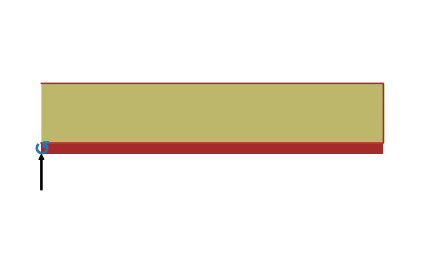

/home/abhimhamane/anaconda3/envs/streamlit-env/lib/python3.9/site-packages/sympy/plotting/plot.py:1618: RuntimeWarning: invalid value encountered in double_scalars
  cos_theta = dot_product / (vector_a_norm * vector_b_norm)


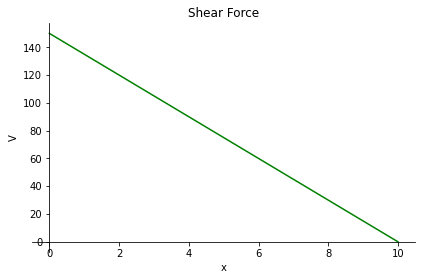

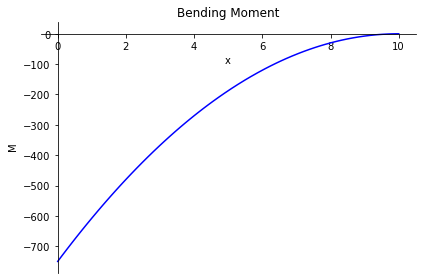

In [2]:
##### Cantilever Beam
L = 10.0
E = 25000
I = 0.000525

b1 = Beam(L, E, I)

R1 = sympy_variable("R_0")

M0 = sympy_variable("M_0")

#r_end = sympy_variable("R_10")




b1.apply_load(R1, 0, -1)
b1.apply_load(M0, 0, -2)
#b1.apply_load(r_end, L, -1)
#b1.apply_load(m_end, L, -2)


#b1.apply_load(10.0, 2.5, -1)
b1.apply_load(15.0, 0.0, 0, end=L)

b1.bc_deflection.append((0,0))
b1.bc_deflection.append((L, 0))
#b1.bc_slope.append((0,0))
#b1.bc_slope.append((L,0))

b1.solve_for_reaction_loads(R1, M0)
b1.reaction_loads



#b1.solve_for_reaction_loads(R1 ,M0, R2)
#v= b1.plot_shear_force()
sh_eq = b1.shear_force()
bm_eqn = b1.bending_moment()
#slp_eqn = b1.slope()
#defl_eqn = b1.deflection()
ax_x = np.arange(0, L, 0.05)
#print(ax_x)
x = sympy.symbols("x")
shear_y = []

for i in ax_x:
    shear_y.append(sh_eq.subs(x, i))

_pen = b1.draw()
_pen.show()

b1.plot_shear_force()
b1.plot_bending_moment()

shear_eqn = b1.shear_force()
moment_eqn = b1.bending_moment()

In [3]:
x = sympy.symbols("x")

C1 = sympy.symbols("C1")
C2 = sympy.symbols("C2")

integrated_slp = sympy.integrate(moment_eqn, x)/(E*I) + C1

integrated_defl = sympy.integrate(integrated_slp, x) + C2

In [4]:
integrated_defl.subs(x, 0.0)

C2

In [409]:
_bc = integrated_defl.subs(x, L) 
# C2 = 0
#C1 = 0

In [415]:
_bc

10.0*C1 - 1428.57142857143

In [416]:
_bc = _bc.subs(C2, 0.0)

In [417]:
_bc

10.0*C1 - 1428.57142857143

In [427]:
integrated_defl = integrated_defl.subs(C1, 0.0)
integrated_defl = integrated_defl.subs(C2, 0.0)

In [419]:
integrated_defl

-28.5714285714286*SingularityFunction(x, 0, 2) + 1.9047619047619*SingularityFunction(x, 0, 3) - 0.0476190476190476*SingularityFunction(x, 0.0, 4) + 0.0476190476190476*SingularityFunction(x, 10.0, 4)

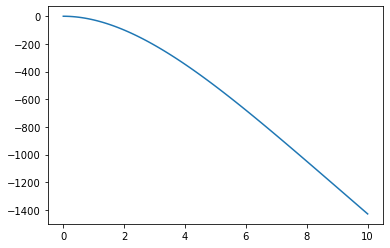

In [428]:
ax_x = list(np.linspace(0, L, 100))
x = sympy.symbols("x")
defl_val = []
for i in ax_x:
    defl_val.append(integrated_defl.subs(x, i))

plt.plot(ax_x, defl_val)

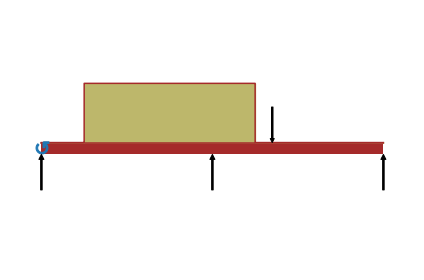

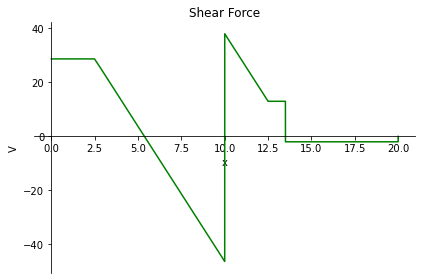

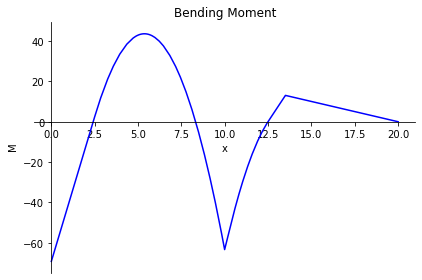

sympy.core.add.Add

In [5]:
L = 20.0
E = 25000
I = 0.000525

## Continuous Beam ##
cont_beam = Beam(L, E,I)
left_sprt = "Fixed"
right_sprt = "Roller"

num_spans = 2
num_sprts = num_spans + 1
sprt_spacing = L/num_spans

sprt_locations = list(np.linspace(0, L, num_sprts))

beam_viz = Beam(L,E,I)

beam_viz.apply_support(0, "fixed")


for loc in sprt_locations[1:-1]:
    beam_viz.apply_support(loc, "roller")

beam_viz.apply_support(L, "roller")

#cont_pen = beam_viz.draw()
#cont_pen.show()
beam_sprt = beam_viz.applied_loads

sprt_symbs = []
sprt_order = []
sprt_start_loc = []

for spr in beam_sprt:
    sprt_symbs.append(spr[0])
    sprt_order.append(spr[2])
    sprt_start_loc.append(spr[1])

for i in range(len(sprt_order)):
    if sprt_order[i] == -1:
        cont_beam.apply_load(sprt_symbs[i], sprt_start_loc[i], -1)
        cont_beam.bc_deflection.append((sprt_start_loc[i], 0))
    elif sprt_order[i] == -2:
        cont_beam.apply_load(sprt_symbs[i], sprt_start_loc[i], -2)
        cont_beam.bc_slope.append((sprt_start_loc[i], 0))


cont_beam.apply_load(10, 2.5, 0, 12.5)
cont_beam.apply_load(15, 13.5, -1)

_pen = cont_beam.draw()
_pen.show()

cont_beam.solve_for_reaction_loads(sprt_symbs[0], sprt_symbs[1], sprt_symbs[2], sprt_symbs[3])

cont_beam.reaction_loads
cont_beam.plot_shear_force()
cont_beam.plot_bending_moment()
#cont_beam.plot_slope()

shear_eqn = cont_beam.shear_force()
moment_eqn = cont_beam.bending_moment()
type(moment_eqn)
#Deflection does not work

In [90]:
x = sympy.symbols("x")

C1 = sympy.symbols("C1")
C2 = sympy.symbols("C2")

integrated_slp = sympy.integrate(moment_eqn, x)/(E*I) + C1

integrated_slp 


C1 - 5.27574829931972*SingularityFunction(x, 0, 1) + 1.09270153061224*SingularityFunction(x, 0, 2) - 0.126984126984127*SingularityFunction(x, 2.5, 3) + 3.21171768707483*SingularityFunction(x, 10.0, 2) + 0.126984126984127*SingularityFunction(x, 12.5, 3) - 0.571428571428572*SingularityFunction(x, 13.5, 2) + 0.0765331632653061*SingularityFunction(x, 20.0, 2)

In [91]:
integrated_defl = sympy.integrate(integrated_slp, x) + C2

In [92]:
integrated_defl.subs(C2, 0.0)

C1*x - 2.63787414965986*SingularityFunction(x, 0, 2) + 0.364233843537415*SingularityFunction(x, 0, 3) - 0.0317460317460318*SingularityFunction(x, 2.5, 4) + 1.07057256235828*SingularityFunction(x, 10.0, 3) + 0.0317460317460318*SingularityFunction(x, 12.5, 4) - 0.19047619047619*SingularityFunction(x, 13.5, 3) + 0.0255110544217687*SingularityFunction(x, 20.0, 3)

In [75]:
integrated_slp.subs(x, 0.0)

C1

In [93]:

integrated_defl = integrated_defl.subs(C1, 0.0)
integrated_defl = integrated_defl.subs(C2, 0.0)

In [94]:
integrated_defl

-2.63787414965986*SingularityFunction(x, 0, 2) + 0.364233843537415*SingularityFunction(x, 0, 3) - 0.0317460317460318*SingularityFunction(x, 2.5, 4) + 1.07057256235828*SingularityFunction(x, 10.0, 3) + 0.0317460317460318*SingularityFunction(x, 12.5, 4) - 0.19047619047619*SingularityFunction(x, 13.5, 3) + 0.0255110544217687*SingularityFunction(x, 20.0, 3)

In [101]:
ax_x = list(np.linspace(0, 20.0, 100))
x = sympy.symbols("x")
defl_val = []
for i in ax_x:
    defl_val.append(integrated_defl.subs(x, i))

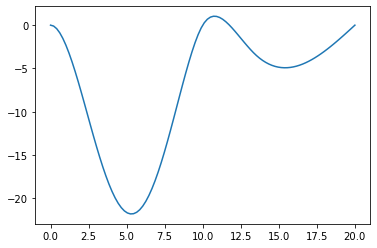

In [103]:
plt.plot(ax_x, defl_val)

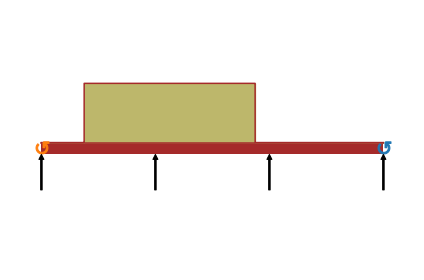

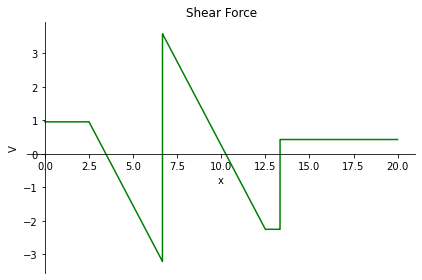

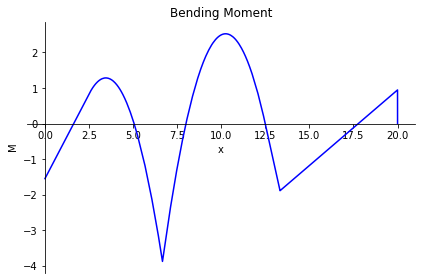

In [185]:
L = 20.0
E = 25000.0 * (10**6)
I = 0.0005175

## Continuous Beam ##
cont_beam = Beam(L, E,I)
left_sprt = "Fixed"
right_sprt = "Fixed"

num_spans = 3
num_sprts = num_spans + 1
sprt_spacing = L/num_spans

sprt_locations = list(np.linspace(0, L, num_sprts))

beam_viz = Beam(L,E,I)

beam_viz.apply_support(0, "fix")


for loc in sprt_locations[1:-1]:
    beam_viz.apply_support(loc, "roller")

beam_viz.apply_support(L, "fix")

#cont_pen = beam_viz.draw()
#cont_pen.show()
beam_sprt = beam_viz.applied_loads

sprt_symbs = []
sprt_order = []
sprt_start_loc = []

for spr in beam_sprt:
    sprt_symbs.append(spr[0])
    sprt_order.append(spr[2])
    sprt_start_loc.append(spr[1])

for i in range(len(sprt_order)):
    if sprt_order[i] == -1:
        cont_beam.apply_load(sprt_symbs[i], sprt_start_loc[i], -1)
        cont_beam.bc_deflection.append((sprt_start_loc[i], 0))
    elif sprt_order[i] == -2:
        cont_beam.apply_load(sprt_symbs[i], sprt_start_loc[i], -2)
        cont_beam.bc_slope.append((sprt_start_loc[i], 0))


cont_beam.apply_load(1, 2.5, 0, 12.5)
#cont_beam.apply_load(15, 14, -1)

_pen = cont_beam.draw()
_pen.show()

cont_beam.solve_for_reaction_loads(sprt_symbs[0], sprt_symbs[1], sprt_symbs[2],sprt_symbs[3],sprt_symbs[4],sprt_symbs[5])

cont_beam.reaction_loads
cont_beam.plot_shear_force()
cont_beam.plot_bending_moment()
#cont_beam.plot_slope()

shear_eqn = cont_beam.shear_force()
moment_eqn = cont_beam.bending_moment()
mmt_eq = cont_beam.bending_moment()

In [154]:
cont_beam.applied_loads

[(R_5.00000000000000, 5.00000000000000, -1, None),
 (R_10.0000000000000, 10.0000000000000, -1, None),
 (R_15.0000000000000, 15.0000000000000, -1, None),
 (1, 2.50000000000000, 0, 12.5)]

In [186]:
x = sympy.symbols("x")

C1 = sympy.symbols("C1")
C2 = sympy.symbols("C2")

integrated_slope = sympy.integrate(moment_eqn, x)/(E*I) + C1

integrated_slope

C1 - 1.19906289139379e-7*SingularityFunction(x, 0, 1) + 3.68074426328499e-8*SingularityFunction(x, 0, 2) - 1.28824476650564e-8*SingularityFunction(x, 2.5, 3) + 2.62580515297908e-7*SingularityFunction(x, 6.66666666666667, 2) + 1.28824476650564e-8*SingularityFunction(x, 12.5, 3) + 1.03528205515296e-7*SingularityFunction(x, 13.3333333333333, 2) - 7.30788155304986e-8*SingularityFunction(x, 20.0, 1) - 1.64427334943629e-8*SingularityFunction(x, 20.0, 2)

In [187]:
integrated_defln = sympy.integrate(integrated_slope, x) + C2

In [158]:
integrated_slope.subs(x, 10)

C1 - 0.316220238095239

In [172]:
integrated_defln.subs(x, 15.0)

15.0*C1 + C2 + 2.28371298532825e-7

In [188]:
integrated_defln = integrated_defln.subs(C2, 0.0)

In [105]:
integrated_defln.subs(x, 15.0) 

15.0*C1 + 8.35476190476193

In [189]:
integrated_defln = integrated_defln.subs(C1, 0.0)


In [190]:
ax_x = list(np.linspace(0, L, 100))
x = sympy.symbols("x")
defl_valu = []
for i in ax_x:
    defl_valu.append(integrated_defln.subs(x, i))

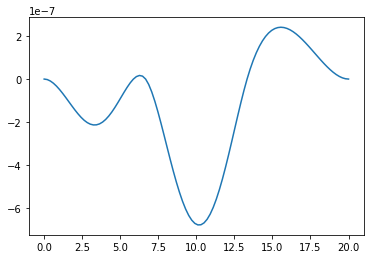

In [191]:
plt.plot(ax_x, defl_valu)